# Fall Detection from Thermal Images
SYDE 362

Prof. J. Kofman

Group 6 - Semin Bae, Jacob Chan, Janno Joulu, Chenlei Shen, Hassan Almusawi

Big thank you to [Prof. Alex Wong](http://www.eng.uwaterloo.ca/~a28wong/) for the guidance and help!

### Initialization

In [1]:
"""
Imports
"""
from skimage import measure
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline
import numpy as np
import cv2
from scipy.stats import rayleigh
import scipy
import pandas as pd

#### Feature Extraction Methods

In [2]:
"""
This distribution serves as the prior to our "thresholding" algorithm.
"""
mu = 517.51266145227532
std = 781.92552992055425
size= 5000
pdf_fitted = rayleigh.pdf(scipy.arange(size), mu, std)

In [3]:
def get_CCA_from_image(image, threshold = 115, show_image=False):
    """
    Get connected components from image
    params
    - image - string filename of the image
    - threshold - int threshold in which to binarize the image
    - show_image - boolean whether to show the image in output 
    returns
    - stats[max_area_index] - properties of the bounding box -> [left, top, width, height, area]
    - chosen_box - The cropped image of the bounding box
    - thresh - The thresholded image
    - img - The image itself
    """
    img = cv2.imread(image,0)
    h,w = img.shape[:2]
    if show_image:
        fig,ax = plt.subplots(1)
    ret, thresh = cv2.threshold(img,threshold,255,cv2.THRESH_BINARY)
    
    output = cv2.connectedComponentsWithStats(thresh, 8, cv2.CV_32S)
    num_labels = output[0]
    labels = output[1]
    stats = output[2]
    centroids = output[3]

    max_area_index=-1
    for i in range(len(stats)):
        if stats[i][0]==0 and stats[i][1]==0:
            continue
        if show_image:
            ax.add_patch(
                patches.Rectangle(
                    (stats[i][0], stats[i][1]),
                    stats[i][2],
                    stats[i][3],
                    fill=False,      # remove background
                    color='red'
                )
            )
        if max_area_index==-1:
            max_area_index=i
        elif stats[i][4] > stats[max_area_index][4]:
            max_area_index=i
    if show_image:
        ax.imshow(thresh, cmap='gray')
        plt.show()
    chosen_box = thresh[stats[max_area_index][1]:stats[max_area_index][1]+stats[max_area_index][3],stats[max_area_index][0]:stats[max_area_index][0]+stats[max_area_index][2]]
    return stats[max_area_index], chosen_box, thresh, img


def get_best_threshold(img_filename, pdf, start=30, max_steps =100, alpha=1, show_graph = False):
    """
    Get best threshold for given image. Maximizes the "score" function, where the score is defined as:
        score = (1 - ratio_of_white_to_total_pixels) * P(area)
    where P(area) is the prior
    params
    - img_filename - string filename of the image
    - pdf - scipy probability distribution of prior
    - start - "starting" threshold 
    - max_steps - number of steps to take
    - alpha - how much to step by
    - show_graph - boolean whether to show the graphs in output
    returns
    - index - threshold chosen
    - final_chosen_box - cropped image of bounding box
    - final_stats - properties of the bounding box -> [left, top, width, height, area]
    - final_thresh - The thresholded image
    - final_img - The image itself
    - score - score calculated
    """
    index = -1
    final_chosen_box = None
    final_stats = []
    final_img = None
    final_thresh = None
    thresholds = np.arange(start,start+max_steps,alpha)
    min_score = -1
    if show_graph:
        areas = []
        ratios = []
        scores=[]
    for i in thresholds:
        stats, chosen_box, thresh, img = get_CCA_from_image(img_filename, i, show_image=False)
        ratio = get_ratio_of_image(chosen_box)
        score= (1-ratio)*pdf[chosen_box.size]
        if show_graph:
            scores.append(score)
            areas.append(chosen_box.size)
            ratios.append(ratio)
        if score > min_score:
            min_score = score
            index = i
            final_chosen_box = chosen_box
            final_stats = stats
            final_thresh = thresh
            final_img = img
    if show_graph:
        plt.title('ratios')
        plt.xlabel('threshold value')
        plt.ylabel('ratio of white pixels to black pixels')
        plt.plot(ratios)
        plt.show()
        plt.title('areas')
        plt.xlabel('threshold value')
        plt.ylabel('area of bounding box')
        plt.plot(areas)
        plt.show()
        plt.title('scores')
        plt.xlabel('threshold value')
        plt.ylabel('score')
        plt.plot(scores)
        return index, final_chosen_box, final_stats, final_thresh, final_img, areas,ratios
    return index, final_chosen_box, final_stats, final_thresh, final_img, score

def get_ratio_of_image(img):
    """
    Gets ratio of image
    params
    - img - proposed bounding box of image 
    returns
    - ratio - # white pixels / # total pixels
    """
    a=cv2.countNonZero(img)
    h,w = img.shape[:2]
    return float(float(a)/(float(h)*float(w)))

def get_rotated_box(image_filename, output = False, max_area = 2700):
    """
    Gets rotated box. Uses cv2.minAreaRect. Not used in final design.
    params
    - image_filename - string filename of image
    - output - boolean to show image in output
    - max_area - hard coded limit on bounding box area
    returns
    - area - area of bounding box
    - bb_ratio - ratio of bounding box
    """
    images = []
    threshold, chosen_box, stats, thresh, img = get_best_threshold(image_filename, start=40)
    im2,contours,hierarchy = cv2.findContours(thresh, 1, 2)
    areas = []
    for cont in contours:
        areas.append(cv2.contourArea(cont))
    areas = np.array(areas)
    cont = contours[np.argmax(areas[areas < max_area])]
    rect = cv2.minAreaRect(cont)
    if output:
        box = cv2.boxPoints(rect)
        box = np.int0(box)
        images.append(thresh)
        a = cv2.drawContours(thresh,[box],0,(255, 255,0),2)
        plt.imshow(thresh, cmap="gray")
        plt.show()
    return rect[1][0]*rect[1][1], max(rect[1][0]/rect[1][1],rect[1][1]/rect[1][0])

def get_features(filename, pdf, output=False):
    """
    Gets features.
    params
    - filename - string filename of image
    - pdf - scipy distribution as prior
    - output - boolean to show output
    returns
    - features - list of all features
    """
    index, final_chosen_box, final_stats, final_thresh, final_img, score = get_best_threshold(filename, pdf)
    features = []
    area = final_stats[2]*final_stats[3]
    features.append(area)
    bb_ratio =max((float(final_stats[2])/float(final_stats[3])),(float(final_stats[3])/float(final_stats[2])))
    features.append(bb_ratio)
    hu_moments = cv2.HuMoments(cv2.moments(final_chosen_box))
    features.extend(hu_moments.T[0].tolist())
    variance = np.var(final_chosen_box)
    features.append(variance) 
    if output:
        fig,ax = plt.subplots(1)
        ax.add_patch(
            patches.Rectangle(
                (final_stats[0], final_stats[1]),
                final_stats[2],
                final_stats[3],
                fill=False,      # remove background
                color='red'
            )
        )
        print "threshold used: " + str(index)
        ax.imshow(final_thresh, cmap='gray')
        plt.show()
        print "area: "+str(area)
        print "bb_ratio: "+ str(bb_ratio)
        print "hu_moments: "+np.array2string(hu_moments.T[0])
        print "variance: "+str(variance)
    return features

## Example Image Process

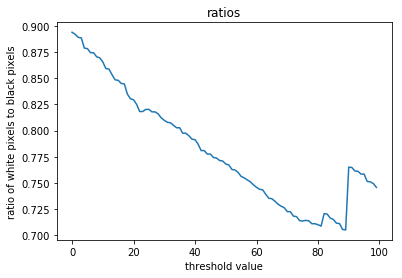

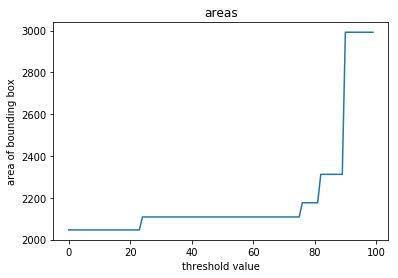

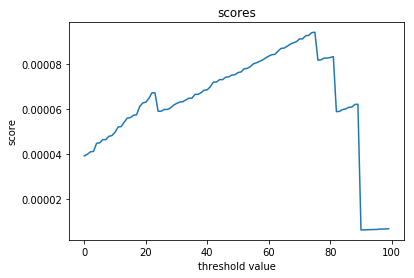

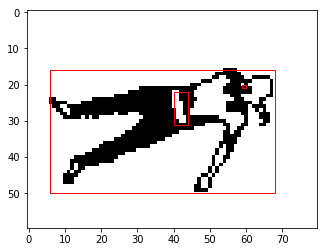

In [4]:
x = get_best_threshold('full-dataset/dataset1(rgb22).jpg', pdf_fitted ,show_graph=True)
img=get_CCA_from_image('full-dataset/dataset1(rgb22).jpg', x[0], show_image=True)

#### Classification Methods

In [5]:
def scale_features(features, scl):
    """
    scale features.
    params
    - features - numpy.ndarray 2D array of features
    - scalers - fit scaler from training
    returns
    - scaled_features - scaled features
    """
    if not scl:
        return
    if len(features) != (scl.min_).shape[0]:
        return
    return scl.transform([features])

def classify_with_scaled_features(scaled_features, clf, probabilities = False):
    """
    Classify after scaling.
    params
    - scaled_features - scaled features
    - classifier - classifier to use
    - probabilities - boolean to output probabilities with class pred.
    returns
    - predictions - predictions
    """
    if not clf:
        return
    if probabilities:
        return clf.predict(scaled_features), clf.predict_proba(scaled_features)
    return clf.predict(scaled_features)

#### Training Methods

Models used:
- Logistic Regression
- SVM (Linear Kernel)
- SVM (RBF)
- Gaussian Process Classifier
- Quadratic Discriminant Analysis
- k-Nearest Neighbors

Data used:
- "regression_3.csv"
- "regression_3_test.csv"

Split:
- 25%

Scaling used:
- `sklearn.preprocessing.MinMaxScaler`

In [6]:
"""
To train
"""
import pandas as pd
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, precision_score, recall_score
from sklearn.preprocessing import MinMaxScaler
from sklearn import svm
from sklearn import gaussian_process
from sklearn import discriminant_analysis
from sklearn import neighbors

def classify(clf, X_train, X_test, y_train, y_test):
    """
    classifies.
    params
    - clf - classifier
    - X_train - training features
    - X_test - testing features
    - y_train - training labels
    - y_test - testing labels
    returns
    - clf - classifier
    - accuracy_score - metric
    - mean_squared_error - metric
    - r2_score - metric
    - precision_score - metric
    - recall_score - metric
    """
    clf.fit(X_train, y_train)
    prediction = clf.predict(X_test)
    return clf, accuracy_score(y_test, prediction), mean_squared_error(y_test, prediction),r2_score(y_test, prediction), precision_score(y_test, prediction), recall_score(y_test, prediction)

def train(dataset="dataset.csv",scale=True, features=['falling','area','bb_ratio','hu1','hu2','hu3','hu4','hu5','hu6','hu7','variance'], test_size=0.25 ):
    """
    trains. Models used were logistic regression, linear SVM, non-linear SVM (RBF), GPC, QDA, and k-NN.
    params
    - dataset - csv file
    - scale - boolean whether to scale features
    - features - list of desired features
    - test_size - float from 0 to 1 to describe proportion of test_size
    returns
    - clf_df - pd.DataFrame of classifiers with metrics
    """
    classifiers = [("Logistic Regression",linear_model.LogisticRegression()),
                   ("Linear SVM",svm.SVC()), 
                   ("Non-Linear SVM",svm.SVC(gamma=2, C=1, probability=True)), 
                   ("GPC", gaussian_process.GaussianProcessClassifier()), 
                   ("QDA",discriminant_analysis.QuadraticDiscriminantAnalysis()),
                   ("kNN",neighbors.KNeighborsClassifier())]
    performance = {}
    data = pd.read_csv(dataset)
    data = data.reset_index()[features]
    y = data.falling
    X = data.drop(['falling'], axis=1)
    if scale:
        scaler = MinMaxScaler()
        X_scaled = scaler.fit(X.values)
        X_scaled = scaler.transform(X.values)
        X = X_scaled
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    for i in classifiers:
        performance[i[0]] = []
        for j in range(0,100):
            x = [i[0]]
            x.extend(classify(i[1],X_train, X_test, y_train, y_test))
            performance[i[0]].append(x)
    to_return = []
    for i in performance:
        for j in np.array(performance[i]).reshape((-1,7)):
            to_return.append(j)
    clf_df = pd.DataFrame(data=to_return, columns=['type','clf','acc','mse','r2','prec','rec'])
    if scale:
        return clf_df, scaler
    return clf_df

#### Data Preprocessing Methods

In [7]:
def build_dataset(directory, output=False):
    """
    builds the dataset
    params
    - directory - string of folder with images
    - output - boolean whether or not to output
    returns
    - dataset - pd.DataFrame of features
    """
    import os
    pdf_fitted = rayleigh.pdf(scipy.arange(5000), 517.51266145227532, 781.92552992055425)
    feature_list = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if '.jpg' in file:
                feature_vector = []
                filepath = os.path.join(root, file)
                if 'lying' in filepath:
                    feature_vector.append(1)
                else:
                    feature_vector.append(0)
                features = get_features(filepath, pdf_fitted, output)
                feature_vector.extend(features)
                feature_list.append(feature_vector)
    return pd.DataFrame(data=feature_list,columns = ['falling','area','bb_ratio','hu1','hu2','hu3','hu4','hu5','hu6','hu7','variance'])

In [8]:
def preprocess(output=False):
    """
    preprocesses, save as csv
    params
    - output - boolean whether or not to output
    returns
    - dataset - pd.DataFrame of features
    """
    df = build_dataset("./dataset/", output)
    df.to_csv('dataset.csv')
    return df

### Model Selection
Model selection: best average `accuracy_score`

Classifier selection: best `accuracy_score`

In [9]:
def select_model(performance, best = False):
    """
    selects model
    params
    - best - outputs the best classifier based on average accuracy score
    returns
    - if best
        - classifier - best classifier based on above criteria
    - else
        - classifiers - pd.DataFrame of classifiers
    """
    if best:
        best_class = None
        best_score = -1
        for i in performance:
            if performance[i]['avg_score'] > best_score:
                best_score = performance[i]['avg_score']
                best_class = i
        classifier = performance[best_class]\
        ['clf'][np.argmax(performance[best_class]['accuracy_score'])]
        return classifier
    else:
        classifiers = []
        for i in performance:
            classifiers.append(performance[i]['clf'][np.argmax(performance[i]['accuracy_score'])])
        return classifiers

### Model Exporting

In [10]:
def export_model(classifier, scaler, clf_name = 'classifier.pkl',scl_name = 'scaler.pkl'):
    """
    exports specified classifier and scaler
    params
    - classifier - classifier to be exported
    - scaler - scaler to be exported
    - clf_name - desired filename for classifier
    - scl_name - desired filename for scaler
    """
    from sklearn.externals import joblib
    joblib.dump(classifier, clf_name) 
    joblib.dump(scaler, scl_name) 

## Building Dataset

In [11]:
perf, scl = train()

In [12]:
perf.groupby('type').describe()['acc']

,count,mean,std,min,25%,50%,75%,max
type,,,,,,,,
GPC,100.0,0.904762,1.115816e-16,0.904762,0.904762,0.904762,0.904762,0.904762
Linear SVM,100.0,0.928571,1.115816e-16,0.928571,0.928571,0.928571,0.928571,0.928571
Logistic Regression,100.0,0.904762,1.115816e-16,0.904762,0.904762,0.904762,0.904762,0.904762
Non-Linear SVM,100.0,0.904762,1.115816e-16,0.904762,0.904762,0.904762,0.904762,0.904762
QDA,100.0,0.738095,1.115816e-16,0.738095,0.738095,0.738095,0.738095,0.738095
kNN,100.0,0.928571,1.115816e-16,0.928571,0.928571,0.928571,0.928571,0.928571


## Quick Start
### Model Importing

In [13]:
def import_model(clf_name = 'classifier.pkl',scl_name = 'scaler.pkl'):
    """
    exports specified classifier and scaler
    params
    - clf_name - desired classifier
    - scl_name - desired scaler
    returns
    - classifier
    - scaler
    """
    from sklearn.externals import joblib
    clf = joblib.load(clf_name)
    scl = joblib.load(scl_name)
    return clf, scl

### Classification Example

In [14]:
clf, scl = import_model(clf_name="classifier_svmrbf.pkl")
features = get_features('latest.jpg', pdf_fitted)
print features
scaled_features = scale_features(features, scl)
print scaled_features
print classify_with_scaled_features(scaled_features, clf, True)

[2664, 1.945945945945946, 0.0009743570416946188, 3.5363295421404633e-07, 7.249538940610172e-12, 4.5316198213948075e-12, 1.64582980141422e-23, 1.0531653275105492e-16, -2.009384013936279e-23, 8091.2552755458182]
[[ 0.87328312  0.3993994   0.11714451  0.08869879  0.00310256  0.00379461
   0.05543299  0.18067753  0.59127328  0.28837408]]
(array([1]), array([[ 0.00896855,  0.99103145]]))
